In [ ]:
!nvidia-smi

#### Load data


In [ ]:
!ls '/content/sample_data/'
!unzip '/content/sample_data/dogs.zip'

#### Visualizing the images with code

In [ ]:
# images/Images/n02116738-African_hunting_dog/n02116738_9924.jpg
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('images/Images/n02116738-African_hunting_dog/n02116738_9798.jpg')
# BGR - RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
print(img.shape)

In [ ]:
print(img)

In [ ]:
#Loading a VGG16 pretrained and making inference.
from tensorflow.keras.applications import VGG16

In [ ]:
modelo_VGG16 = VGG16() # Pretrained from ImageNet

In [ ]:
modelo_VGG16.summary()

##### Making predictions over the pretrained model with one of the images

In [ ]:
img = cv2.resize(img, (224, 224))

In [ ]:
import numpy as np
#image_batch = np.stack(img, axis=0)
image_batch_manual = np.array(img)
image_batch_manual = image_batch_manual[np.newaxis, :, ...]

In [ ]:
image_batch_manual.shape

In [ ]:
prediction = modelo_VGG16.predict(image_batch_manual)

In [ ]:
prediction

In [ ]:
prediction_class = np.argmax(prediction, axis=1)

In [ ]:
prediction_class

#### Fine tuning the VGG16 model

In [ ]:
modelo_VGG16 = VGG16(include_top=False, input_shape=(224, 224, 3))

In [ ]:
modelo_VGG16.summary()

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Dropout

In [ ]:
# Añadimos capas
head_model = modelo_VGG16.output
head_model = Flatten()(head_model)
head_model = Dense(512, activation='relu')(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(120, activation='softmax')(head_model)

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
model = Model(inputs=modelo_VGG16.input, outputs=head_model)

In [ ]:
print(model.summary())

#### backbone NO trainable. compile model

In [ ]:
for layer in modelo_VGG16.layers:
  layer.trainable = False

In [ ]:
model = Model(inputs=modelo_VGG16.input, outputs=head_model)

In [ ]:
print(model.summary())

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.001)
model.compile(optimizer=Adam(),loss="categorical_crossentropy", metrics=['accuracy'])

#### reading dataset to train it with TensorFlow

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
data_dir = 'images/Images/'
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [ ]:
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

In [ ]:
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

## Training the model

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

#### Checking model results

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Increasing data

#### Callbacks

In [ ]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import datetime

In [ ]:
#callback Tensorboard
tensorboard_callback = TensorBoard(log_dir='logs/fit/'+datetime.datetime.now().strftime('%Y%m%d-%H%M%S'), histogram_freq=1)
modelcheckpoint_callback = ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True, verbose=1)
earlystopping_callback = EarlyStopping(patience=5)

In [ ]:
!pip install albumentations

In [ ]:
import albumentations as A

augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.5)
])

In [ ]:
def apply_augmentations(image):
  augmented = augmentations(image=image)
  return augmented['image']

In [ ]:
data_dir = 'images/Images/'
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=apply_augmentations
)

In [ ]:
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[tensorboard_callback, modelcheckpoint_callback, earlystopping_callback]
)

#### Checking options to enhance model

In [ ]:
'''
Opciones para mejorar los resultados:
1. Cambiar la arquitectura de red a una más actual (por ejemplo una Efficientnet).
2. Cambiar las capas de fine-tuning (por ejemplo, añadir Dropout).
3. Añadir más épocas.
4. Cambiar learning rate. (Ajuste de hiperparámetros).
5. Ajustar el data augmentation.

DATOS:
6. Revisar que los datos estén bien.
7. Leer solo determinadas clases del modelo.
8. Revisar balanceo de los datos.
'''

#### After reviewing options, reading only 2 clases to train the model with fewer data

In [ ]:
# Leemos solo 2 clases
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    classes=['n02085620-Chihuahua','n02085782-Japanese_spaniel']
)
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    classes=['n02085620-Chihuahua','n02085782-Japanese_spaniel']
)

In [ ]:
modelo_VGG16 = VGG16(include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Añadimos capas
head_model = modelo_VGG16.output
head_model = Flatten()(head_model)
head_model = Dense(512, activation='relu')(head_model)
#head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation='softmax')(head_model)

In [ ]:
model = Model(inputs=modelo_VGG16.input, outputs=head_model)

In [ ]:
for layer in modelo_VGG16.layers:
  layer.trainable = False

In [ ]:
model.summary()

In [ ]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=Adam(),loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[tensorboard_callback, modelcheckpoint_callback, earlystopping_callback]
)

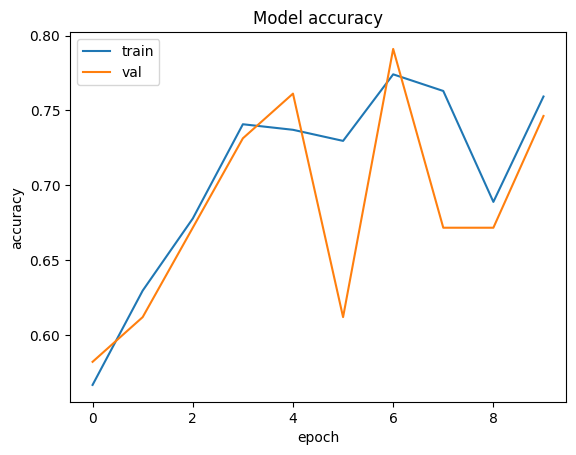

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

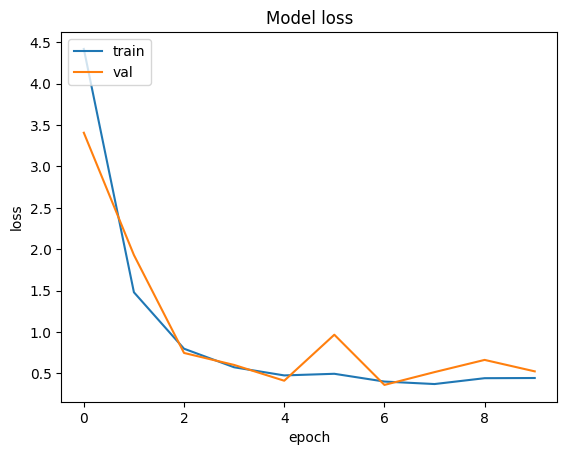

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(validation_generator)

In [ ]:
predictions

In [ ]:
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
predicted_classes

In [ ]:
validation_generator.classes

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(validation_generator.classes, predicted_classes)

In [ ]:
print(cm)

<Axes: >

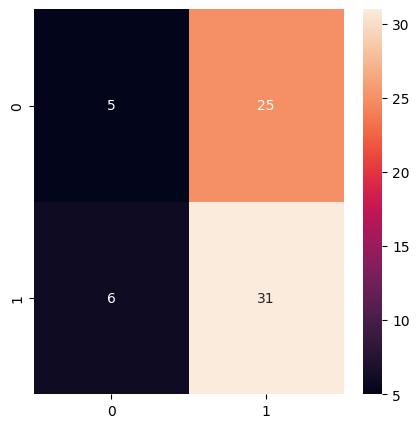

In [ ]:
import seaborn as sn

plt.figure(figsize=(5,5))
sn.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report

cr = classification_report(validation_generator.classes, predicted_classes)
print(cr)